In [2]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6
import numpy as np
import pandas as pd
import requests
from config import api_key
import eia
import datetime
import re
from sqlalchemy import create_engine
from datetime import datetime

#### Part One: Import All Data

In [60]:
# test if api_key variable works
# (remove this line output when making public)
api_key

'021bf1d89256205c8528b6d4475485b3'

In [3]:
# save variable to call in api data w/ key
api = eia.API(api_key)

In [62]:
# test one api ending; import to pandas dataframe
test_import = api.data_by_series(series='TOTAL.TETCBUS.M')
eia_df = pd.DataFrame(test_import)
eia_df.head()


,"Total Primary Energy Consumption, Monthly (Trillion Btu)"
1973 01,7226.265
1973 02,6594.709
1973 03,6524.198
1973 04,5944.336
1973 05,6074.551


In [63]:
# create numeric index (unique identifier)
eia_df = eia_df.reset_index()
eia_df = eia_df.rename(columns={"index":"Time"})
eia_df.head()

,Time,"Total Primary Energy Consumption, Monthly (Trillion Btu)"
0,1973 01,7226.265
1,1973 02,6594.709
2,1973 03,6524.198
3,1973 04,5944.336
4,1973 05,6074.551


#### Part Two: Reshape data for analysis

In [64]:
# create object for existing timestamp column and an empty list for converted timestamp
timestamp = eia_df["Time"]
datetime_list = []

In [65]:
# fill empty list with dates converted to datetime
for i in timestamp:
    i = i.replace(" ", "-")
    i = i + "01"
    i = pd.to_datetime(i, infer_datetime_format = True)
    datetime_list.append(i)

In [66]:
datetime_list[:10]

[Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00')]

In [67]:
# add datetime array to total consumption df
eia_df['Date'] = datetime_list
eia_df.head()

,Time,"Total Primary Energy Consumption, Monthly (Trillion Btu)",Date
0,1973 01,7226.265,1973-01-01
1,1973 02,6594.709,1973-02-01
2,1973 03,6524.198,1973-03-01
3,1973 04,5944.336,1973-04-01
4,1973 05,6074.551,1973-05-01


In [98]:
# new dataframe with just datetime(as index) and usage columns
raw_df = eia_df[["Date", "Total Primary Energy Consumption, Monthly (Trillion Btu)"]]
# raw_df = raw_df.set_index("Date")
raw_df.head()


,Date,"Total Primary Energy Consumption, Monthly (Trillion Btu)"
0,1973-01-01,7226.265
1,1973-02-01,6594.709
2,1973-03-01,6524.198
3,1973-04-01,5944.336
4,1973-05-01,6074.551


In [4]:
raw_df.to_csv("clean_data.csv", index=False)

NameError: name 'raw_df' is not defined

In [5]:
raw_df=pd.read_csv("clean_data.csv")
raw_df = raw_df.set_index("Date")

In [6]:
raw_df.head()


,"Total Primary Energy Consumption, Monthly (Trillion Btu)"
Date,
1973-01-01,7226.265
1973-02-01,6594.709
1973-03-01,6524.198
1973-04-01,5944.336
1973-05-01,6074.551


# Start time series testing here

In [7]:
import plotly
import plotly.plotly as ply
import cufflinks as cf
from plotly.plotly import plot_mpl
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='disco_nap', api_key='84gBOgUqBKJnD1eR2tFV')

raw_df.iplot(title="Energy Consumption Jan 1973-May 2018")

# Decomposition
### Here we can see there is an upward trend. We can use statsmodels to perform a decomposition of this time series. The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

In [15]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(raw_df, model='multiplicative', freq=12)
# fig = result.plot()
# url = plot_mpl(fig)

PlotlyRequestError: Account limit reached: Your account is limited to creating 25 charts. To continue, you can override or delete existing charts or you can upgrade your account at: https://plot.ly/products/cloud

In [19]:
import plotly.tools as tls
# tls.embed(url)

# Below we perform a grid search for the optimal p, d, q parameters-
#### We want the lowes AIC score. AIC is an estimator of the relative quality of statistical models for a given set of data. The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.

-- it runs this and automatically chooses the best one. In this case the best one is the AIC score of 7068.90 so we use the order parameters of (1,1,1) and seasonal order parameters of (2,1,1,12)

-- You can see these results below in the variable "results"

In [20]:
# run a stepwise model to try different lag scenerios to find the optimal p, d, q value for trend and seasonality

from pyramid.arima import auto_arima
stepwise_model = auto_arima(raw_df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7080.558, BIC=7101.978, Fit time=1.732 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=7416.031, BIC=7424.599, Fit time=0.064 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=7286.517, BIC=7303.653, Fit time=0.779 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7103.099, BIC=7120.235, Fit time=1.406 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=7078.750, BIC=7104.455, Fit time=2.283 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=7217.997, BIC=7239.418, Fit time=1.695 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=7081.711, BIC=7111.700, Fit time=8.111 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=7299.505, BIC=7316.642, Fit time=0.447 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=7084.164, BIC=7118.437, Fit time=9.410 seconds
Fit ARIMA: order=(0, 1, 1) s

In [21]:
# this will print the optimal p, d, q values for trend and seasonal
print(stepwise_model)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')


In [23]:
# Here we are training on the data from 1973 through the end of 2015. The rest is test data.
train = raw_df.loc['1973-01-01':'2015-12-01']
test = raw_df.loc['2016-01-01':]
len(test)


33

# Fit the ARIMA model

In [24]:
# fit the ARIMA model
results=stepwise_model.fit(train)
# results


In [25]:
#

future_forecast = stepwise_model.predict(n_periods=33)
# 21 is the length of the test data
# below prints the "forecast" for the test data
# print(future_forecast)



In [26]:

# we graph the actual data on top of the forecasted data that we created. It follows the same trend so we know that it was successful 
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
# pd.concat([test,future_forecast],axis=1).iplot()


In [27]:
# calculate % error of 2017 predictions using ARIMA

actual = sum(test["Total Primary Energy Consumption, Monthly (Trillion Btu)"])
prediction = sum(future_forecast['Prediction'])

error = (actual - prediction) / actual
percent_error = error*100

# print(f"ARIMA prediction error: {percent_error}%")

# Fit the SARIMAX model

In [28]:
import statsmodels.api as sm
# SARIMAX= Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

model=sm.tsa.statespace.SARIMAX(raw_df["Total Primary Energy Consumption, Monthly (Trillion Btu)"],order=(1,1,1), seasonal_order=(2,1,1,12))
results=model.fit()

/Users/christinavavoulis/anaconda3/envs/PythonData/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [29]:
# this is predicting the data based on our test data 
raw_df["Forecast"]=results.predict(start=500, end=549, dynamic=True)
# raw_df[["Total Primary Energy Consumption, Monthly (Trillion Btu)", "Forecast"]].plot(figsize=(30,8))

In [30]:
raw_df["Forecast"]=results.predict(start=500, end=549, dynamic=True)
# raw_df[["Total Primary Energy Consumption, Monthly (Trillion Btu)", "Forecast"]][500:].plot(figsize=(30,8))

In [31]:
predictions = raw_df["Forecast"].tail(49)
# len(predictions)

In [32]:
actual = raw_df["Total Primary Energy Consumption, Monthly (Trillion Btu)"][500:]
# sum(actual)

In [60]:
s_prediction = sum(predictions)
actual = sum(raw_df["Total Primary Energy Consumption, Monthly (Trillion Btu)"][500:])

error = (actual - s_prediction) / actual
percent_error = error*100

# print(f"SARIMA prediction error: {percent_error}%")

# Sarima has the closest prediction, so we will move forward with future predictions using SARIMAX

In [62]:
# 500 refers to how many months you will predict into the future
from pandas.tseries.offsets import DateOffset
future_dates=[raw_df.index[-1]+str((DateOffset(months=x))) for x in range (0,300)]

In [63]:
futures_datest_df=pd.DataFrame(index=future_dates[1:], columns=raw_df.columns)

In [66]:
futures_datest_df.head()

,"Total Primary Energy Consumption, Monthly (Trillion Btu)",Forecast
2018-09-01<DateOffset: months=1>,NaN,NaN
2018-09-01<DateOffset: months=2>,NaN,NaN
2018-09-01<DateOffset: months=3>,NaN,NaN
2018-09-01<DateOffset: months=4>,NaN,NaN
2018-09-01<DateOffset: months=5>,NaN,NaN


In [67]:
future_df=pd.concat([raw_df, futures_datest_df])

In [68]:
future_df.tail()

,"Total Primary Energy Consumption, Monthly (Trillion Btu)",Forecast
2018-09-01<DateOffset: months=295>,NaN,NaN
2018-09-01<DateOffset: months=296>,NaN,NaN
2018-09-01<DateOffset: months=297>,NaN,NaN
2018-09-01<DateOffset: months=298>,NaN,NaN
2018-09-01<DateOffset: months=299>,NaN,NaN


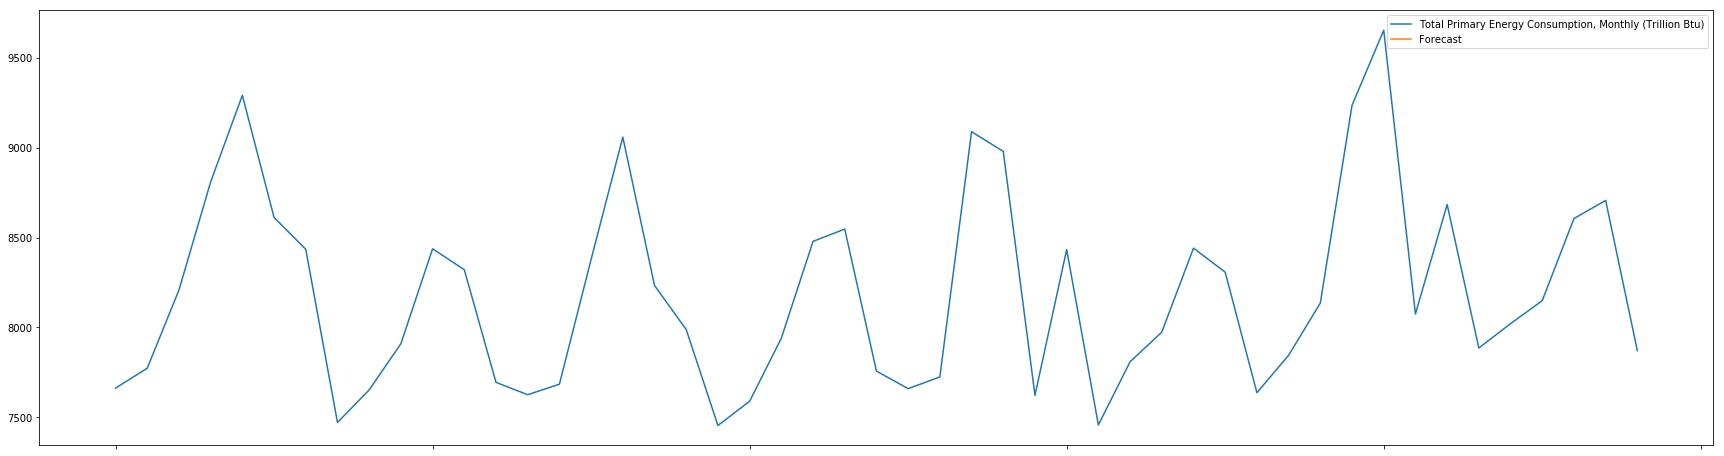

In [69]:
# this chart below is projecting into the future. The start value is when you start predicting.
# 549 is the length of our data so I am predicting 151 months out. This number is easily adjusted but you have to adjust the number above (currently 48)
future_df["Forecast"]=results.predict(start= 548, end= 700, dynamic=True)
future_df[["Total Primary Energy Consumption, Monthly (Trillion Btu)", "Forecast"]][500:].plot(figsize=(30,8))

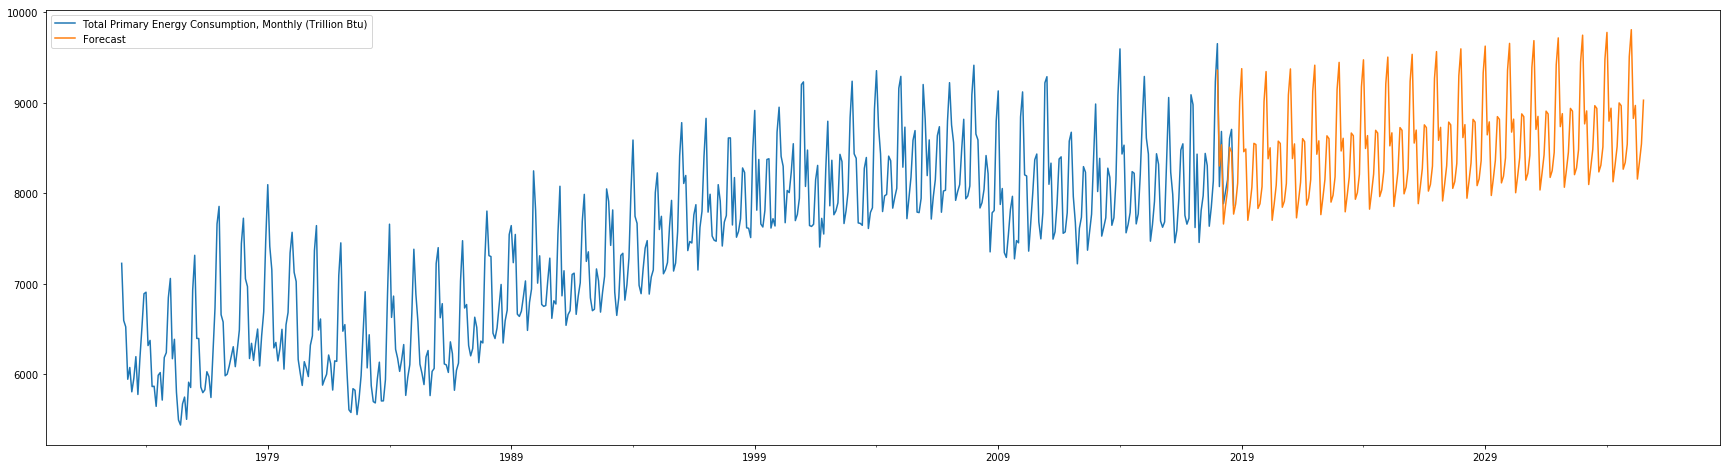

In [34]:
future_df["Forecast"]=results.predict(start= 540, end=750, dynamic=True)
future_df[["Total Primary Energy Consumption, Monthly (Trillion Btu)", "Forecast"]].plot(figsize=(30,8))

# Manual ARIMA Analysis Below
## Prior to importing autoarima, we tried several methods of achieving stationarity, so that we could pick the optimal p, d, q values.

## The steps for manual testing are below.

##  Test stationarity
### If mean is not constant, data is not stationary. Scale the data in various ways to figure out the best way to achieve stationarity.
#### We test for stationarity in two ways: a visual test and a statistical test
- VISUAL TEST: plot rolling mean and stdev for a visual of whether data is stationary
    - if data is stationary, it the mean should be close to a straight line with no slope
- STATS TEST: run Dickey-Fuller test for statistical confirmation of whether data is stationary
    - if data is stationary, the P-value should be < 0.05 and the absolute value of the Test Statistic should be greater than the absolute value of the Critical Value

In [35]:
# create function to create rolling mean and stdev, plot for visual test, and DF for stat test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determine rolling stats
    movingAverage=timeseries.rolling(window=12).mean()
    movingStd=timeseries.rolling(window=12).std()
    
    #plot rolling stats
    orig=plt.plot(timeseries, color="blue", label="Original")
    mean=plt.plot(movingAverage, color="red", label="Rolling Mean")
    std=plt.plot(movingStd, color="black", label="Rolling STD")
    plt.legend(loc="best")
    plt.title("Rolling Mean and STD")
    plt.show(block=False)
     
    #perform Dickey-Fuller test
    print("Results of Dickey Fuller test:")
    dftest = adfuller(timeseries["Total Primary Energy Consumption, Monthly (Trillion Btu)"], autolag = 'AIC')
    dfoutput=pd.Series(dftest[0:4], index=["Test Statistic", "P-Value",'# Lags Used',"# of Obsv Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key]=value
    print(dfoutput)
    

### Run this function on scaled data:

#### https://otexts.com/fpp2/stationarity.html
- Raw data (for baseline)
- Log scale
- Log scale minus moving average
- Differencing:
    - on Log scale
    - on Log scale minus moving average
- Exponential weighting
- Differencing (log scale) + Exponential weighting
- Seasonal Decomposition

This shows one way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

As well as looking at the time plot of the data, the ACF plot is also useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly. Also, for non-stationary data, the value of r1 is often large and positive.

### Test with raw data

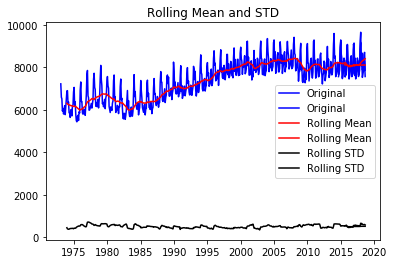

Results of Dickey Fuller test:
Test Statistic           -0.995665
P-Value                   0.754842
# Lags Used              14.000000
# of Obsv Used          534.000000
Critical Value (1%)      -3.442655
Critical Value (5%)      -2.866968
Critical Value (10%)     -2.569661
dtype: float64


In [36]:
# this is how we know the raw data is not stationary

test_stationarity(raw_df)

## Test with log scale

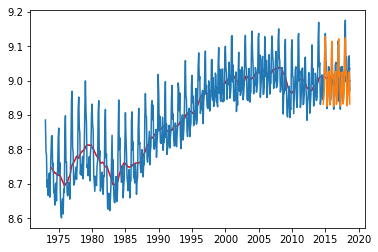

In [37]:
# create new df with log scaled data
raw_df_logScale=np.log(raw_df)

#create a rolling mean of log scaled data
raw_df_log_smooth = raw_df_logScale.rolling(window = 12).mean()

#plot both
plt.plot(raw_df_log_smooth, color = 'red')
plt.plot(raw_df_logScale)
plt.show()

# this data does not appear stationary
# sometimes it is easier to visualize without the stdev because the y-scale adjusts

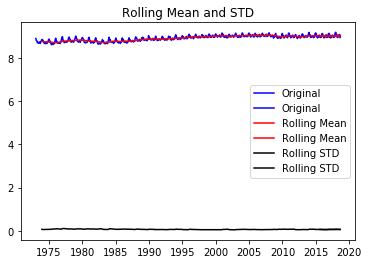

Results of Dickey Fuller test:
Test Statistic           -1.133286
P-Value                   0.701617
# Lags Used              18.000000
# of Obsv Used          530.000000
Critical Value (1%)      -3.442749
Critical Value (5%)      -2.867009
Critical Value (10%)     -2.569683
dtype: float64


In [38]:
test_stationarity(raw_df_logScale)
# DF confirms this data is not stationary

## Test with log scale minus moving average

In [39]:
# reset rolling mean and stdev of log scaled data
movingAverage = raw_df_logScale.rolling(window=12).mean()
movingStd = raw_df_logScale.rolling(window=12).std()

# create df of Log - Moving Avg
logScaleMinusMovingAverage_df = raw_df_logScale - movingAverage
logScaleMinusMovingAverage_df.dropna(inplace=True)
logScaleMinusMovingAverage_df.head()

,"Total Primary Energy Consumption, Monthly (Trillion Btu)",Forecast
Date,,
2015-08-01,0.014832,0.026026
2015-09-01,-0.063903,-0.071391
2015-10-01,-0.071327,-0.055955
2015-11-01,-0.058130,-0.035926
2015-12-01,0.032610,0.085498


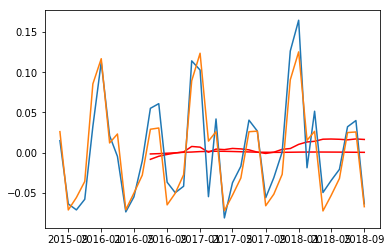

In [40]:
# reset rolling mean of Log - Moving Avg 
movingAverage = logScaleMinusMovingAverage_df.rolling(window=12).mean()

# plot both
plt.plot(movingAverage, color = 'red')
plt.plot(logScaleMinusMovingAverage_df)
plt.show()

# this data appears stationary

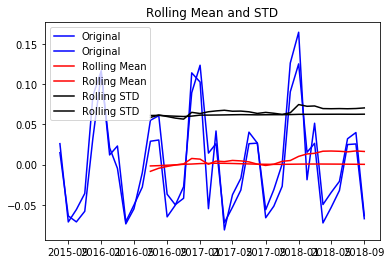

Results of Dickey Fuller test:
Test Statistic          -3.080046
P-Value                  0.028066
# Lags Used              9.000000
# of Obsv Used          28.000000
Critical Value (1%)     -3.688926
Critical Value (5%)     -2.971989
Critical Value (10%)    -2.625296
dtype: float64


In [41]:
test_stationarity(logScaleMinusMovingAverage_df)
# DF confirms this data is stationary
# this one is the best P-value so far

## Test with Seasonal Decomposition

In [42]:

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(raw_df)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(raw_df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



ValueError: This function does not handle missing values

In [ ]:
# test stationarity on residual plot after trend and seasonality has been removed 

raw_df_decompose = residual
raw_df_decompose.dropna(inplace=True)
test_stationarity(raw_df_log_decompose)

# DF shows this is by far the highest confidence model

# The seasonal decomposition is the best way to achieve stationarity for this dataset. We can use this scale to determine the best p, d, and q values

# Begin forecasting here

### ARIMA model

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences

#### Selecting p, q, and d values

1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(raw_df_log_decompose, nlags=20)
lag_pacf = pacf(raw_df_log_decompose, nlags=20, method = 'ols')
#ols is 'ordinary least squares' method

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='-', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(raw_df_log_decompose)), linestyle='-', color='gray')
plt.axhline(y=1.96/np.sqrt(len(raw_df_log_decompose)), linestyle='-', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='-', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(raw_df_log_decompose)), linestyle='-', color='gray')
plt.axhline(y=1.96/np.sqrt(len(raw_df_log_decompose)), linestyle='-', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
